__DATA CLEANING__

In [1]:
import re
import html
from bs4 import BeautifulSoup
import pandas as pd

In [2]:
df = pd.read_csv("../data/paycell_reviews_play_store.csv")
df

,Yorum,Puan,Tarih
0,sakin girmeyin,1,2025-07-19 22:54:03
1,Uygulamada arkadaşını davet et butonu çalışmıy...,4,2025-07-19 15:19:42
2,SMS KODU GELMİYOR,1,2025-07-19 09:00:43
3,geçici olarak IBAN bilgilerine ulaşılamıyor di...,5,2025-07-19 06:27:28
4,onaylayabilmek için telefonumun NFC özelliğini...,1,2025-07-18 14:50:20
...,...,...,...
68634,Uygulama Çok İyi Ancak Günlük Giriş Olarak Kre...,5,2017-10-25 19:51:01
68635,Arkadaş turk sel bayi email adresimi yanlış gi...,1,2017-10-25 15:07:58
68636,"Arena of valor oyununa 3,89 nakit cektim oyuna...",3,2017-10-21 10:55:40
68637,Arayuz gercekten cok iyi.,5,2017-10-18 19:05:47


In [3]:
def clean_text(text):
    if pd.isnull(text):
        return ""

    # html silmece
    text = BeautifulSoup(text, 'html.parser').get_text()
    text = html.unescape(text)

    # clasic cleaning
    text = re.sub(r'http\S+|www.\S+', '', text)
    text = re.sub(r'[^\w\sçğıöşüÇĞİÖŞÜ]', '', text, flags=re.UNICODE)
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    text = text.lower()
    text = re.sub(r'\s+', ' ', text).strip()
    
     # emoji silmece
    emoji_pattern = re.compile(
        "["
        "\U0001F600-\U0001F64F"
        "\U0001F300-\U0001F5FF"
        "\U0001F680-\U0001F6FF"
        "\U0001F1E0-\U0001F1FF"
        "\U00002700-\U000027BF"
        "\U0001F900-\U0001F9FF"
        "\U00002600-\U000026FF"
        "]+",
        flags=re.UNICODE
    )
    text = emoji_pattern.sub(r'', text)

    return text


In [4]:
df['Temiz_Yorum'] = df['Yorum'].apply(clean_text)
df[['Yorum', 'Temiz_Yorum']]

,Yorum,Temiz_Yorum
0,sakin girmeyin,sakin girmeyin
1,Uygulamada arkadaşını davet et butonu çalışmıy...,uygulamada arkadaşını davet et butonu çalışmıy...
2,SMS KODU GELMİYOR,sms kodu gelmi̇yor
3,geçici olarak IBAN bilgilerine ulaşılamıyor di...,geçici olarak iban bilgilerine ulaşılamıyor di...
4,onaylayabilmek için telefonumun NFC özelliğini...,onaylayabilmek için telefonumun nfc özelliğini...
...,...,...
68634,Uygulama Çok İyi Ancak Günlük Giriş Olarak Kre...,uygulama çok i̇yi ancak günlük giriş olarak kr...
68635,Arkadaş turk sel bayi email adresimi yanlış gi...,arkadaş turk sel bayi email adresimi yanlış gi...
68636,"Arena of valor oyununa 3,89 nakit cektim oyuna...",arena of valor oyununa nakit cektim oyuna para...
68637,Arayuz gercekten cok iyi.,arayuz gercekten cok iyi


__Zemberek kullanarak yazım hatalarınının tespiti yapıldı bunun sonucunda verimizin temizlenmeye devam etmekte.__

In [5]:
from jpype import startJVM, getDefaultJVMPath, JClass, isJVMStarted

ZEMBEREK_PATH = "zemberek-full.jar"

if not isJVMStarted():
    startJVM(getDefaultJVMPath(), "-ea", f"-Djava.class.path={ZEMBEREK_PATH}")

In [6]:
TurkishSpellChecker = JClass("zemberek.normalization.TurkishSpellChecker")
TurkishMorphology = JClass("zemberek.morphology.TurkishMorphology")
morphology = TurkishMorphology.createWithDefaults()
spell_checker = TurkishSpellChecker(morphology)

I|09:44:07.159|Root lexicon created in 187 ms.                                                                     | DictionarySerializer#getDictionaryItems
I|09:44:07.160|Dictionary generated in 200 ms                                                                      | RootLexicon#defaultBinaryLexicon
I|09:44:07.307|Initialized in 351 ms.                                                                              | TurkishMorphology#createWithDefaults


In [7]:
def correct_spelling(text):
    words = text.split()
    corrected_words = []
    for word in words:
        if spell_checker.check(word):
            corrected_words.append(str(word))  
        else:
            suggestions = spell_checker.suggestForWord(word)
            if not suggestions.isEmpty():
                corrected_words.append(str(suggestions.get(0))) 
            else:
                corrected_words.append(str(word))
    return " ".join(corrected_words)


In [8]:
df["yazim_hatasiz"] = df["Temiz_Yorum"].astype(str).apply(correct_spelling)
df[["Yorum", "yazim_hatasiz"]]

,Yorum,yazim_hatasiz
0,sakin girmeyin,sakin girmeyin
1,Uygulamada arkadaşını davet et butonu çalışmıy...,uygulamada arkadaşını davet et butonu çalışmıy...
2,SMS KODU GELMİYOR,ses kodu gelmiyor
3,geçici olarak IBAN bilgilerine ulaşılamıyor di...,geçici olarak ilan bilgilerine ulaşılamıyor di...
4,onaylayabilmek için telefonumun NFC özelliğini...,onaylayabilmek için telefonumun nbc özelliğini...
...,...,...
68634,Uygulama Çok İyi Ancak Günlük Giriş Olarak Kre...,uygulama çok iyi ancak günlük giriş olarak kre...
68635,Arkadaş turk sel bayi email adresimi yanlış gi...,arkadaş Türk sel bayi mail adresimi yanlış gir...
68636,"Arena of valor oyununa 3,89 nakit cektim oyuna...",arena of Valon oyununa nakit çektim oyuna para...
68637,Arayuz gercekten cok iyi.,arayüz gerçekten çok iyi


__PREPROCESSING__ 

STOPWORDS 
and TOKENAZATION

__Türkçe stopwordlere erişerek bunları veriden temizleme işlemi yapıldı__

In [9]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
import string

In [11]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/enisba/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [12]:
stop_words = set(stopwords.words("turkish"))

def remove_stopwords(text):
    tokens = text.split() 
    filtered_tokens = [word.lower() for word in tokens 
                       if word.lower() not in stop_words and
                       word not in string.punctuation and
                       len(word) > 2]
    return filtered_tokens

df = df[df["yazim_hatasiz"].notnull()]
df["tokens"] = df["yazim_hatasiz"].astype(str).apply(remove_stopwords)
df[["Yorum", "yazim_hatasiz", "tokens"]]

,Yorum,yazim_hatasiz,tokens
0,sakin girmeyin,sakin girmeyin,"[sakin, girmeyin]"
1,Uygulamada arkadaşını davet et butonu çalışmıy...,uygulamada arkadaşını davet et butonu çalışmıy...,"[uygulamada, arkadaşını, davet, butonu, çalışm..."
2,SMS KODU GELMİYOR,ses kodu gelmiyor,"[ses, kodu, gelmiyor]"
3,geçici olarak IBAN bilgilerine ulaşılamıyor di...,geçici olarak ilan bilgilerine ulaşılamıyor di...,"[geçici, olarak, ilan, bilgilerine, ulaşılamıy..."
4,onaylayabilmek için telefonumun NFC özelliğini...,onaylayabilmek için telefonumun nbc özelliğini...,"[onaylayabilmek, telefonumun, nbc, özelliğinin..."
...,...,...,...
68634,Uygulama Çok İyi Ancak Günlük Giriş Olarak Kre...,uygulama çok iyi ancak günlük giriş olarak kre...,"[uygulama, iyi, ancak, günlük, giriş, olarak, ..."
68635,Arkadaş turk sel bayi email adresimi yanlış gi...,arkadaş Türk sel bayi mail adresimi yanlış gir...,"[arkadaş, türk, sel, bayi, mail, adresimi, yan..."
68636,"Arena of valor oyununa 3,89 nakit cektim oyuna...",arena of Valon oyununa nakit çektim oyuna para...,"[arena, valon, oyununa, nakit, çektim, oyuna, ..."
68637,Arayuz gercekten cok iyi.,arayüz gerçekten çok iyi,"[arayüz, gerçekten, iyi]"


__ZEMBEREK USING STEMMING AND LEMMAZATION__

__köklerini bulmak adına zemberek kullanıldı ve bu şekilde köklerine ulaşıldı__

In [13]:
def lemmatizeTokens(tokens, morphology):
    lemmas = []
    for tok in tokens:
        analyses = morphology.analyzeAndDisambiguate(tok).bestAnalysis()
        if analyses.size() > 0:
            lemma = str(analyses.get(0).getLemmas()[0])
            lemmas.append(lemma if lemma != 'UNK' else tok)
        else:
            lemmas.append(tok)
    return lemmas

df["lemmas"] = df["tokens"].apply(lambda x: lemmatizeTokens(x, morphology))

In [14]:
df[["Yorum", "tokens", "lemmas"]]

,Yorum,tokens,lemmas
0,sakin girmeyin,"[sakin, girmeyin]","[sakin, gir]"
1,Uygulamada arkadaşını davet et butonu çalışmıy...,"[uygulamada, arkadaşını, davet, butonu, çalışm...","[uygula, arkadaş, davet, buton, çalış, program..."
2,SMS KODU GELMİYOR,"[ses, kodu, gelmiyor]","[ses, kod, gel]"
3,geçici olarak IBAN bilgilerine ulaşılamıyor di...,"[geçici, olarak, ilan, bilgilerine, ulaşılamıy...","[geçici, ol, ilan, bilgi, ulaş, de, sorun, çöz]"
4,onaylayabilmek için telefonumun NFC özelliğini...,"[onaylayabilmek, telefonumun, nbc, özelliğinin...","[onayla, telefon, nbc, özellik, ol, zorunlu, s..."
...,...,...,...
68634,Uygulama Çok İyi Ancak Günlük Giriş Olarak Kre...,"[uygulama, iyi, ancak, günlük, giriş, olarak, ...","[uygula, iyi, ancak, günlük, giriş, ol, kredi,..."
68635,Arkadaş turk sel bayi email adresimi yanlış gi...,"[arkadaş, türk, sel, bayi, mail, adresimi, yan...","[arkadaş, türk, sel, bayi, mail, adres, yanlış..."
68636,"Arena of valor oyununa 3,89 nakit cektim oyuna...","[arena, valon, oyununa, nakit, çektim, oyuna, ...","[arena, valon, oyun, nakit, çek, oyun, para, g..."
68637,Arayuz gercekten cok iyi.,"[arayüz, gerçekten, iyi]","[arayüz, gerçekten, iyi]"


In [15]:
df = df[df["lemmas"].apply(lambda x: len(x) > 0)]

__veri setinde çok fazla geçen ve bir anlam ifade etmeyen kelimelerin çıkarıldı ve daha anlamlı bir veri seti elde edildi.__

In [16]:
remove_words = set(["uygula", "yap", "et", "ver", "al", "bir", "ol", "de", "ben", "gel"])

def clean_lemmas(val):
    try:
        if isinstance(val, str):
            val = ast.literal_eval(val)
        return [w for w in val if w.lower() not in remove_words]
    except Exception as e:
        print(f"Hata: {e} → {val}")
        return []

df["lemmas"] = df["lemmas"].apply(clean_lemmas)

In [17]:
def clean_lemmas(lemmas):
    return [w for w in lemmas if len(w) > 2]

df["lemmas"] = df["lemmas"].apply(clean_lemmas)

df = df[df["lemmas"].apply(lambda x: len(x) > 0)]

__Preprocessing adımları ve datanın ne şekilde değiştiğine dair örnekler bu şekildeler__

In [18]:
df.head()


,Yorum,Puan,Tarih,Temiz_Yorum,yazim_hatasiz,tokens,lemmas
0,sakin girmeyin,1,2025-07-19 22:54:03,sakin girmeyin,sakin girmeyin,"[sakin, girmeyin]","[sakin, gir]"
1,Uygulamada arkadaşını davet et butonu çalışmıy...,4,2025-07-19 15:19:42,uygulamada arkadaşını davet et butonu çalışmıy...,uygulamada arkadaşını davet et butonu çalışmıy...,"[uygulamada, arkadaşını, davet, butonu, çalışm...","[arkadaş, davet, buton, çalış, program, kilitle]"
2,SMS KODU GELMİYOR,1,2025-07-19 09:00:43,sms kodu gelmi̇yor,ses kodu gelmiyor,"[ses, kodu, gelmiyor]","[ses, kod]"
3,geçici olarak IBAN bilgilerine ulaşılamıyor di...,5,2025-07-19 06:27:28,geçici olarak iban bilgilerine ulaşılamıyor di...,geçici olarak ilan bilgilerine ulaşılamıyor di...,"[geçici, olarak, ilan, bilgilerine, ulaşılamıy...","[geçici, ilan, bilgi, ulaş, sorun, çöz]"
4,onaylayabilmek için telefonumun NFC özelliğini...,1,2025-07-18 14:50:20,onaylayabilmek için telefonumun nfc özelliğini...,onaylayabilmek için telefonumun nbc özelliğini...,"[onaylayabilmek, telefonumun, nbc, özelliğinin...","[onayla, telefon, nbc, özellik, zorunlu, saçma..."


__veriler düzgün şekilde kaydedildi__

In [19]:
df[["lemmas", "Puan", "Tarih"]].to_csv("../data/preprocessed_review.csv", index = False)

__Veri hakkında bilgi etme amaçlı olarak burada bazı görselleşirmeler yapıldı ve sonuç olarak elde edilen veriler bu şekilde__

In [20]:
df = pd.read_csv("../data/preprocessed_review.csv")

In [21]:
df.head()

,lemmas,Puan,Tarih
0,"['sakin', 'gir']",1,2025-07-19 22:54:03
1,"['arkadaş', 'davet', 'buton', 'çalış', 'progra...",4,2025-07-19 15:19:42
2,"['ses', 'kod']",1,2025-07-19 09:00:43
3,"['geçici', 'ilan', 'bilgi', 'ulaş', 'sorun', '...",5,2025-07-19 06:27:28
4,"['onayla', 'telefon', 'nbc', 'özellik', 'zorun...",1,2025-07-18 14:50:20


In [22]:
df['review_length'] = df['lemmas'].apply(lambda x: len(str(x).split()))
df['review_length'].describe()

count    65964.000000
mean         5.588594
std          8.105329
min          1.000000
25%          1.000000
50%          2.000000
75%          7.000000
max        103.000000
Name: review_length, dtype: float64

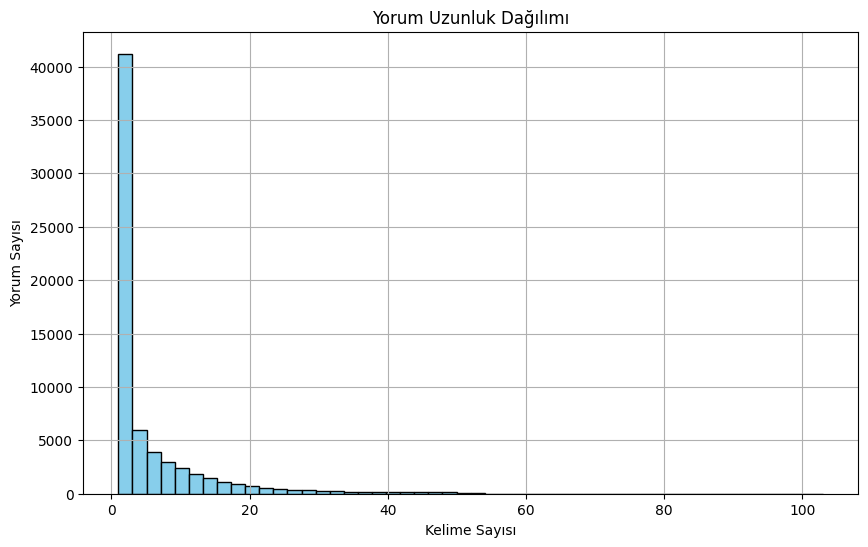

In [24]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.hist(df['review_length'], bins=50, color='skyblue', edgecolor='black')
plt.title("Yorum Uzunluk Dağılımı")
plt.xlabel("Kelime Sayısı")
plt.ylabel("Yorum Sayısı")
plt.grid(True)
plt.show()


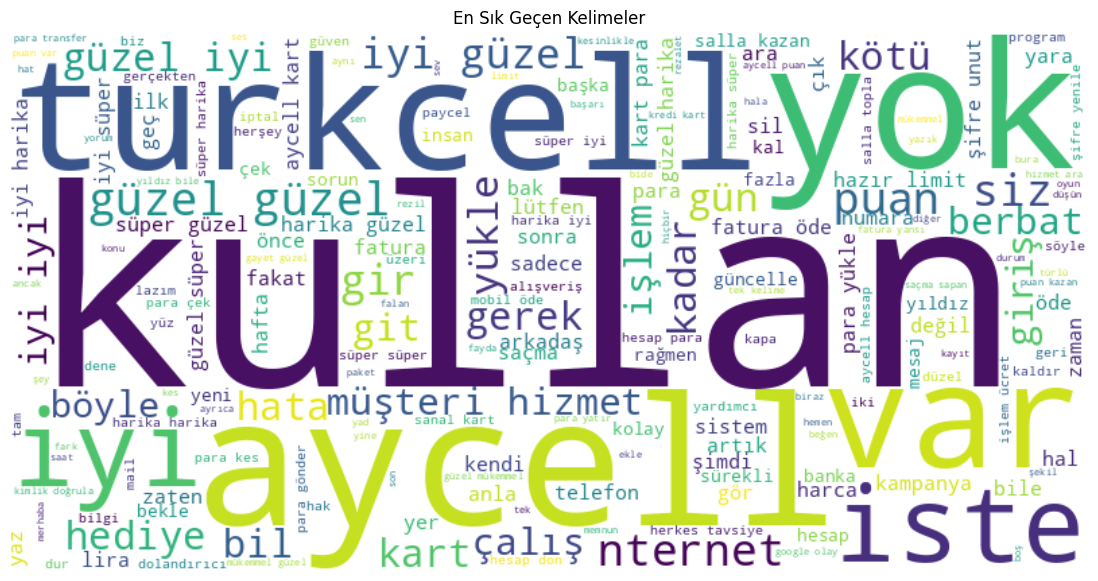

In [26]:
import ast

df['lemmas'] = df['lemmas'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

all_words = [word for tokens in df['lemmas'] for word in tokens]
text = " ".join(all_words)

from wordcloud import WordCloud
import matplotlib.pyplot as plt

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

plt.figure(figsize=(15, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("En Sık Geçen Kelimeler")
plt.show()


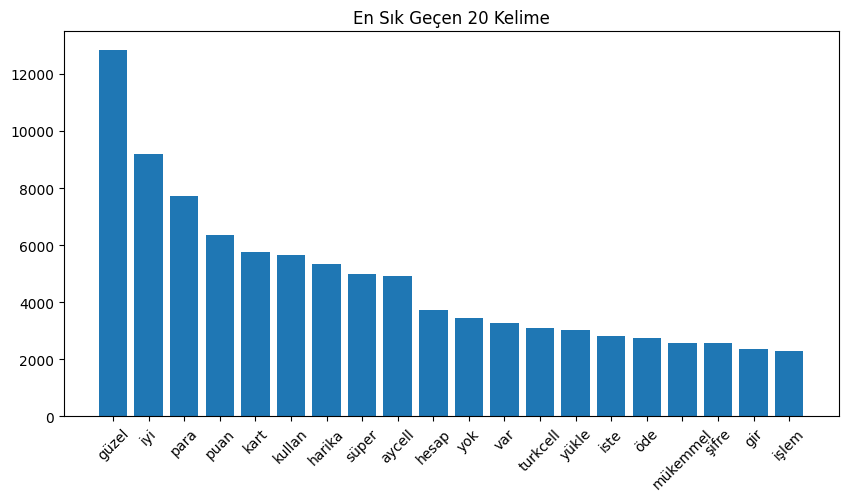

In [27]:
from collections import Counter
import matplotlib.pyplot as plt

all_words = [word for tokens in df["lemmas"] for word in tokens if word.lower() not in stop_words]
word_freq = Counter(all_words).most_common(20)

words, freqs = zip(*word_freq)
plt.figure(figsize=(10,5))
plt.bar(words, freqs)
plt.xticks(rotation=45)
plt.title("En Sık Geçen 20 Kelime")
plt.show()
